# Installations and imports

In [2]:
pip install yfinance

     |████████████████████████████████| 5.5MB 10.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=3171885c6617a961b40f531c3ea3ac05ea4bf757f9f5907c8766ba8380800a71
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import re
import pprint
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import seaborn as sns
from datetime import date,datetime

# Important economic indicators

- https://www.finra.org/investors/insights/key-economic-indicators-every-investor-should-know

- https://www.investopedia.com/articles/personal-finance/020215/top-ten-us-economic-indicators.asp

- https://www.discoveroptions.com/mixed/content/education/articles/bigthreeeconomicindicators.html

# Scraping interest rates - *Nerdwallet*
https://www.nerdwallet.com/blog/mortgages/current-interest-rates/

In [4]:
req = requests.get("https://www.nerdwallet.com/blog/mortgages/current-interest-rates/")
bs = BeautifulSoup(req.content,'lxml')
#bs = bs.prettify()
search = bs.find_all('td')

int_rates = pd.DataFrame()
dates = []
year_30 = []
year_15 = []
apr = []
count = 0

for i in search[:1544]:
  if i.get('class')[0] == 'column-1':
    dates.append(i.text)
    continue
  if i.get('class')[0] == 'column-2':
    year_30.append(i.text)
    continue
  if i.get('class')[0] == 'column-3':
    year_15.append(i.text)
    continue
  if i.get('class')[0] == 'column-4':
    apr.append(i.text)
    continue

int_rates['Date'] = dates
int_rates['Date'] = int_rates['Date'].apply(lambda x: pd.to_datetime(x))
int_rates['30-year rate'] = year_30
int_rates['30-year rate'] = int_rates['30-year rate'].str.extract('(\d\D\d\d)')
int_rates['30-year rate'] = int_rates['30-year rate'].apply(float)
int_rates['15-year rate'] = year_15
int_rates['15-year rate'] = int_rates['15-year rate'].str.extract('(\d\D\d\d)')
int_rates['15-year rate'] = int_rates['15-year rate'].apply(float)
int_rates['APR'] = apr
int_rates['APR'] = int_rates['APR'].str.extract('(\d\D\d\d)')
int_rates['APR'] = int_rates['APR'].apply(float)
int_rates.index = int_rates['Date']
int_rates.head(5)
#search

,Date,30-year rate,15-year rate,APR
Date,,,,
2021-02-26,2021-02-26,3.16,2.45,3.20
2021-02-25,2021-02-25,3.08,2.38,2.92
2021-02-24,2021-02-24,3.01,2.36,2.93
2021-02-23,2021-02-23,2.97,2.34,3.02
2021-02-22,2021-02-22,2.96,2.35,2.76


# Scraping real-time values for major financial indexes - *Yahoo Finance*
https://finance.yahoo.com/

In [5]:
req = requests.get("https://finance.yahoo.com/")
bs = BeautifulSoup(req.content)
search = bs.find_all('script')
script = bs.find("script",text=re.compile("root.App.main")).text

https://stackoverflow.com/questions/39631386/how-to-understand-this-raw-html-of-yahoo-finance-when-retrieving-data-using-pyt

In [6]:
def extract_index_price(ind):
  #Extracting 10000 characters after following the 'quoteData' string which captures the prices for all the indexes
  quotes = script[script.find('quoteData'):script.find('quoteData')+20000]

  #Extracting index price
  price = quotes[quotes.find(ind):quotes.find(ind)+8000]
  current = price[price.find('regularMarketPrice'):price.find('regularMarketPrice')+500]
  prev = price[price.find('regularMarketPreviousClose'):price.find('regularMarketPreviousClose')+500]
  change_per = price[price.find('regularMarketChangePercent'):price.find('regularMarketChangePercent')+500]
  change = price[price.find('regularMarketChange'):price.find('regularMarketChange')+500]

  current = re.findall('("raw":\d+\D\d+|"raw":\d+)',current)[0][6:]
  prev = re.findall('("raw":\d+\D\d+|"raw":\d+)',prev)[0][6:]
  change_per = re.findall('("raw":\d+\D\d+|"raw":\d+)',change_per)[0][6:]
  change = re.findall('("raw":\d+\D\d+|"raw":\d+)',change)[0][6:]
  return (current,prev,change,change_per)

In [7]:
index_futures = ['S&P Futures','Dow Futures','Nasdaq Futures','Russell 2000 Futures','Crude Oil','10-Yr Bond','FTSE 100']
index = ['S&P 500','Dow 30','Nasdaq','Russell 2000','Crude Oil','10-Yr Bond','FTSE 100']

others = ['Gold','Silver','EUR/USD','Nikkei 225','GBP/USE']
price_type = ['regularMarketPrice','regularMarketPreviousClose']
value_curr = []
value_prev = []
value_ch_percent = []
value_ch = []
count = 0

#Checking if the index name has 'Futures'
quotes = script[script.find('quoteData'):script.find('quoteData')+20000]
price = quotes[quotes.find('S&P 500'):quotes.find('S&P 500')+8000]
current = price[price.find('regularMarketPrice'):price.find('regularMarketPrice')+500]

if len(current) == 0: 
  index_list = index_futures
else: 
  index_list = index

for i in index_list:
  count = count + 1
  price_curr,price_prev,price_change,price_change_percent = extract_index_price(i)
  value_curr.append(price_curr)
  value_prev.append(price_prev)
  value_ch_percent.append(price_change_percent)
  value_ch.append(price_change)

indexes = pd.DataFrame()
indexes['Index'] = index_list
indexes['Current'] = value_curr
indexes['Current'] = indexes['Current'].apply(float)
indexes['Prev Close'] = value_prev
indexes['Prev Close'] = indexes['Prev Close'].apply(float)
indexes['Change'] = value_ch
indexes['Change'] = indexes['Change'].apply(float).apply(float)
#indexes['Change Percent'] = value_ch_percent
#indexes['Change Percent'] = indexes['Change Percent'].apply(float)
indexes['Change Percent'] = ((indexes['Current'] - indexes['Prev Close'])/indexes['Prev Close'])*100
indexes.index = indexes['Index']
indexes.head()

,Index,Current,Prev Close,Change,Change Percent
Index,,,,,
S&P 500,S&P 500,3811.150,3829.3400,3829.340000,-0.475017
Dow 30,Dow 30,30932.370,31402.0100,31402.010000,-1.495573
Nasdaq,Nasdaq,13192.346,13119.4310,72.915040,0.555779
Russell 2000,Russell 2000,2201.051,2200.1724,0.878662,0.039933
Crude Oil,Crude Oil,61.660,63.5300,63.530000,-2.943491


# Scraping Covid cases data - *Worldometer*
https://www.worldometers.info/coronavirus/country/us/

In [8]:
req = requests.get("https://www.worldometers.info/coronavirus/country/us/")
bs = BeautifulSoup(req.content)

div = bs.find_all('div')
cov_data = []

for i in div:
  if i.get('id') == "maincounter-wrap":
    cov_data.append(i)

In [9]:
cases = cov_data[0].find('h1')
cases = cases.text
cases_val = cov_data[0].find('span')
cases_val = cases_val.text

deaths = cov_data[1].find('h1')
deaths = deaths.text
deaths_val = cov_data[1].find('span')
deaths_val = deaths_val.text


rec = cov_data[2].find('h1')
rec = rec.text 
rec_val = cov_data[2].find('span')
rec_val = rec_val.text 

print (cases,':',cases_val)
print (deaths,':',deaths_val)
print (rec,':',rec_val)

cases = {'Cases':cases_val,'Deaths':deaths_val,'Recoveries':rec_val}

Coronavirus Cases: : 29,143,480 
Deaths: : 523,296
Recovered: : 19,534,782


# Scraping Covid vaccinations data - *New York Times*

https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html

In [10]:
req = requests.get("https://www.nytimes.com/interactive/2020/us/covid-19-vaccine-doses.html")
bs = BeautifulSoup(req.content)
search = bs.find_all('td')

vac_labels = {'Atleast one shot':'g-cell-color','Two shots':'g-border-r','Doses shipped':'distributed','Total shots given':'g-hide-mobile',
              'Doses used':'g-sm'}

atl_one_shot = 0
two_shots = 0
doses_del = 0
shots_given = 0
doses_used = 0

for i in search: 
  cls = i.get('class')
  #distributed is the last word in the list for all <td> tags for vaccine table
  if cls[-1] == 'g-cell-color':
    atl_one_shot = i.text
  if cls[-1] == 'g-border-r':
    two_shots = i.text
  if cls[-1] == 'distributed':
    doses_del = i.text
  if cls[-1] == 'g-hide-mobile':
    shots_given = i.text
  if cls[-1] == 'g-sm':
    doses_used = i.text
    break
    
vac_values = [atl_one_shot,two_shots,doses_del,shots_given,doses_used]
vac_values = list(map(str.strip,vac_values))

print ("At least 1 shot given: ",atl_one_shot)
print ("Two shots given: ",two_shots)
print ("Total doses delivered: ",doses_del)
print("Total shots given: ",shots_given)
print("Doses used: ",doses_used)

At least 1 shot given:  
14%

Two shots given:  
6.8%

Total doses delivered:  
94,300,910

Total shots given:  
70,454,064

Doses used:  
75%



# Extracting VIX Volatility Index data - *Yahoo Finance API*

### VIX Volatility Index

In [11]:
vix = yf.Ticker("^VIX")

# get stock info
print (vix.info['regularMarketPrice'])
print (vix.info['regularMarketPreviousClose'])
print (vix.info['regularMarketOpen'])
print (vix.info['dayHigh'])
print (vix.info['dayLow'])
print (vix.info['fiftyTwoWeekHigh'])
print (vix.info['fiftyTwoWeekLow'])



28.73
28.89
28.73
30.82
25.23
85.47
19.51


# Scraping Treasury Yield Data - YCharts
- https://ycharts.com/indicators/1_month_treasury_rate
- https://ycharts.com/indicators/3_month_treasury_rate
- https://ycharts.com/indicators/6_month_treasury_rate
- https://ycharts.com/indicators/1_year_treasury_rate
- https://ycharts.com/indicators/3_year_treasury_rate
- https://ycharts.com/indicators/5_year_treasury_rate
- https://ycharts.com/indicators/10_year_treasury_rate
- https://ycharts.com/indicators/20_year_treasury_rate
- https://ycharts.com/indicators/30_year_treasury_rate



In [12]:
def extract_treasury_rates(url):
  req = requests.get(url)
  bs = BeautifulSoup(req.content,'lxml')
  search = bs.find_all('td')

  df_rates = pd.DataFrame()
  rates = []
  dates = []
  count = 0
  count2 = 0

  for i in search:
    if count == 1: 
      dates.append(i.text)
      count = 0
      continue
    if i.get('class'):
      if i.get('class')[0] == 'text-right':  
        count = 1
        rates.append(i.text)
  all_dates = [date.today() - pd.to_timedelta('1D')]
  all_dates.extend(dates[:-1])
  
  df_rates['date'] = all_dates[:50]
  df_rates['date'] = df_rates['date'].apply(pd.to_datetime)
  df_rates['rate'] = rates[:50]
  df_rates['rate'] = df_rates['rate'].apply(str.strip)
  df_rates['rate'] = df_rates['rate'].str.strip('%')

  return df_rates['rate'], df_rates['date']

In [68]:
rate_1m,date_10 = extract_treasury_rates('https://ycharts.com/indicators/1_month_treasury_rate')
rate_3m,date_10 = extract_treasury_rates('https://ycharts.com/indicators/3_month_treasury_rate')
rate_6m,date_10 = extract_treasury_rates('https://ycharts.com/indicators/6_month_treasury_rate')
rate_1,date_10 = extract_treasury_rates('https://ycharts.com/indicators/1_year_treasury_rate')
rate_3,date_10 = extract_treasury_rates('https://ycharts.com/indicators/3_year_treasury_rate')
rate_5,date_10 = extract_treasury_rates('https://ycharts.com/indicators/5_year_treasury_rate')
rate_10,date_10 = extract_treasury_rates('https://ycharts.com/indicators/10_year_treasury_rate')
rate_20,date_20 = extract_treasury_rates('https://ycharts.com/indicators/20_year_treasury_rate')
rate_30,date_30 = extract_treasury_rates('https://ycharts.com/indicators/30_year_treasury_rate')

df_rates = pd.DataFrame()
df_rates['1-mth'] = rate_1m.apply(float)
df_rates['3-mth'] = rate_3m.apply(float)
df_rates['6-mth'] = rate_6m.apply(float)
df_rates['1-yr'] = rate_1.apply(float)
df_rates['3-yr'] = rate_3.apply(float)
df_rates['5-yr'] = rate_5.apply(float)
df_rates['10-yr'] = rate_10.apply(float)
df_rates['20-yr'] = rate_20.apply(float)
df_rates['30-yr'] = rate_30.apply(float)

df_rates['date'] = date_10
df_rates.index = df_rates['date'].apply(pd.to_datetime)

df_rates.head()

,1-mth,3-mth,6-mth,1-yr,3-yr,5-yr,10-yr,20-yr,30-yr,date
date,,,,,,,,,,
2021-02-26,0.04,0.04,0.05,0.08,0.30,0.75,1.44,2.08,2.17,2021-02-26
2021-02-25,0.04,0.04,0.06,0.09,0.34,0.81,1.54,2.25,2.33,2021-02-25
2021-02-24,0.03,0.03,0.05,0.08,0.24,0.62,1.38,2.07,2.24,2021-02-24
2021-02-23,0.03,0.04,0.05,0.08,0.22,0.59,1.37,2.03,2.21,2021-02-23
2021-02-22,0.03,0.03,0.04,0.06,0.22,0.61,1.37,2.02,2.19,2021-02-22


In [71]:
yield_curve = df_rates.iloc[0,:-1]
yield_curve

1-mth    0.04
3-mth    0.04
6-mth    0.05
1-yr     0.08
3-yr      0.3
5-yr     0.75
10-yr    1.44
20-yr    2.08
30-yr    2.17
Name: 2021-02-26 00:00:00, dtype: object

# Scraping unemployment rates - U.S. Bureau of Labor Statistics
https://data.bls.gov/timeseries/LNS14000000

In [14]:
req = requests.get('https://data.bls.gov/timeseries/LNS14000000')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

count = 0
years = 0
time_list = []
rates = []
dates = []

for i in search[6:]:
  count = count + 1
  time_list.append(count)
  rates.append(i.text)
  if count == 12: 
    years = years + 1
    count = 0 

year_list = []
for i in range(date.today().year-years+1,date.today().year+1):
  year_list.extend([i]*12)

count = 0
for i in rates: 
  dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
  count = count + 1

df_unemp_rate = pd.DataFrame()
df_unemp_rate['date'] = dates
df_unemp_rate['unemployment_rate_percent'] = rates  
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].str.strip()
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].replace('',np.nan)
df_unemp_rate['unemployment_rate_percent'] = df_unemp_rate['unemployment_rate_percent'].apply(float)

df_unemp_rate.index = df_unemp_rate['date']
df_unemp_rate = df_unemp_rate.dropna()
df_unemp_rate.head()

,date,unemployment_rate_percent
date,,
2011-01-01,2011-01-01,9.1
2011-02-01,2011-02-01,9.0
2011-03-01,2011-03-01,9.0
2011-04-01,2011-04-01,9.1
2011-05-01,2011-05-01,9.0


# Scraping GDP data - U.S. Inflation Calculator
https://www.usinflationcalculator.com/inflation/historical-inflation-rates/

In [15]:
req = requests.get('https://www.usinflationcalculator.com/inflation/historical-inflation-rates/')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

count = 0
years = 0
time_list = []
rates = []
dates = []

for i in search:
  count = count + 1
  if count == 13:
    years = years + 1
    count = 0 
    continue
  time_list.append(count)
  rates.append(i.text)

time_list = time_list[:-6]
rates = rates[:-6]

year_list = []
for i in range(date.today().year-years+1,date.today().year+1):
  year_list.extend([i]*12)

count = 0
for i in rates: 
  dates.append(pd.to_datetime(str(time_list[count])+'/1/'+str(year_list[count])))
  count = count + 1

df_inflation = pd.DataFrame()
df_inflation['date'] = dates
df_inflation['inflation_rate'] = rates  
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].str.strip()
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].replace('',np.nan)
df_inflation['inflation_rate'] = df_inflation['inflation_rate'].apply(float)

df_inflation.index = df_inflation['date']
df_inflation = df_inflation.dropna()
df_inflation.head()

,date,inflation_rate
date,,
1914-01-01,1914-01-01,2.0
1914-02-01,1914-02-01,1.0
1914-03-01,1914-03-01,1.0
1914-04-01,1914-04-01,0.0
1914-05-01,1914-05-01,2.1


# Scraping Gross Domestic Product (GDP) - Multpl
https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year

In [16]:
req = requests.get('https://www.multpl.com/us-gdp-inflation-adjusted/table/by-year')
bs = BeautifulSoup(req.content,'lxml')
search = bs.find_all('td')

dates = []
gdp = []

count = 0

for i in search: 
  count = count + 1
  if count == 1:
    dates.append(i.text)
  if count == 2: 
    gdp.append(i.text)
    count = 0

df_gdp = pd.DataFrame()
df_gdp['date'] = dates
df_gdp['date'] = df_gdp['date'].apply(pd.to_datetime)
df_gdp['gdp'] = gdp
df_gdp['gdp'] = df_gdp['gdp'].str.strip()
df_gdp['gdp'] = df_gdp['gdp'].str.extract('(\d+\D\d+)')
df_gdp['gdp'] = df_gdp['gdp'].apply(float)
df_gdp.index = df_gdp['date']
df_gdp.head()
    

,date,gdp
date,,
2020-12-31,2020-12-31,18.78
2019-12-31,2019-12-31,19.25
2018-12-31,2018-12-31,18.81
2017-12-31,2017-12-31,18.36
2016-12-31,2016-12-31,17.88


# Dashboard

### Creating a 2x3 grid to display all the information

In [82]:
def dash_create():

  fig3 = plt.figure(constrained_layout=True,figsize=(42,22))
  gs = fig3.add_gridspec(40,3)

  f3_ax1 = fig3.add_subplot(gs[0:10,0])
  #plt.subplot(2,3,1)
  plt.plot(df_unemp_rate['unemployment_rate_percent'],alpha=0.8,label='Unemployment rate (%)',color='green')
  plt.plot(df_inflation.iloc[df_inflation.index>'2011']['inflation_rate'],alpha=0.8,label='Inflation rate (%)',color='blue')
  plt.xticks(rotation=0,size=20)
  plt.xlabel('Timeline',size=25)
  plt.yticks(size=20)
  plt.ylabel('Rate (%)',size=25)
  plt.title('Critical Economic Indicators',size=30)
  #plt.axis('off')
  plt.legend(prop={'size':15})

  f3_ax2 = fig3.add_subplot(gs[10:20,0])
  plt.plot(df_gdp.iloc[df_gdp.index>'2011']['gdp'],marker='o',alpha=0.8,label='GDP',color='orange')
  plt.xticks(rotation=0,size=20)
  plt.xlabel('Timeline',size=25)
  plt.yticks(size=20)
  plt.ylabel('$ (Trillion)',size=25)
  plt.legend(prop={'size':15})

  f3_ax3 = fig3.add_subplot(gs[0:10,1])
  #plt.subplot(2,3,2)
  plt.plot(df_rates['1-mth'],label=df_rates.columns[0],alpha=1)
  plt.plot(df_rates['3-mth'],label=df_rates.columns[1],alpha=1)
  plt.plot(df_rates['6-mth'],label=df_rates.columns[2],alpha=1)
  plt.plot(df_rates['1-yr'],label=df_rates.columns[3],alpha=1)
  plt.plot(df_rates['3-yr'],label=df_rates.columns[4],alpha=1)
  plt.plot(df_rates['5-yr'],label=df_rates.columns[5],alpha=1)
  plt.plot(df_rates['10-yr'],label=df_rates.columns[6],alpha=1)
  plt.plot(df_rates['20-yr'],label=df_rates.columns[7],alpha=1)
  plt.plot(df_rates['30-yr'],label=df_rates.columns[8],alpha=1)
  plt.xticks(rotation=0,size=20)
  plt.xlabel('Timeline',size=25)
  plt.yticks(size=20)
  plt.ylabel('Rate (%)',size=25)
  plt.title('U.S. Treasury Yield Rates (last 3 months)',size=30)
  #plt.axis('off')
  plt.legend(loc='upper left',prop={'size':15})

  f3_ax3 = fig3.add_subplot(gs[10:20,1])
  plt.plot(yield_curve,marker='o')
  plt.xticks(yield_curve.index,rotation=15,size=20)
  plt.yticks(size=20)
  plt.ylabel('Rate (%)',size=25)
  plt.xlabel('Treasury',size=25)
  
  vix_data = {"MarketPrice":vix.info['regularMarketPrice'],"PreviousClose":vix.info['regularMarketPreviousClose'],"MarketOpen":vix.info['regularMarketOpen'],"DayHigh":vix.info['dayHigh'],"DayLow":vix.info['dayLow']}
  f3_ax4 = fig3.add_subplot(gs[0:10,2])  
  #plt.subplot(2,3,3)
  plots = sns.barplot(y="Change Percent", x="Index", data=indexes,alpha=0.8) 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
      plots.annotate(format(bar.get_height(), '.2f'),  
                    (bar.get_x() + bar.get_width() / 2,bar.get_height()+0.6), ha='center', va='center', 
                    size=20, xytext=(0,8), 
                    textcoords='offset points')  
  plt.xlabel('Index',size=25)
  plt.ylabel('Change (%)',size=25)
  plt.title('Major Indexes',size=30)
  #plt.axis('off')
  plt.xticks(size=20)
  plt.yticks(size=20)

  f3_ax4 = fig3.add_subplot(gs[10:20,2])  
  #plt.subplot(2,3,3)
  plots = sns.barplot(y="Current", x="Index", data=indexes,alpha=0.8) 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
      plots.annotate(format(bar.get_height(), '.2f'),  
                    (bar.get_x() + bar.get_width() / 2,bar.get_height()+0.6), ha='center', va='center', 
                    size=20, xytext=(0,8), 
                    textcoords='offset points')  
  plt.xlabel('Index',size=25)
  plt.ylabel('Current Value',size=25)
  #plt.title('Major Indexes (current value)',size=25)
  #plt.axis('off')
  plt.xticks(size=20)
  plt.yticks(size=20)

  vix_data = {"MarketPrice":vix.info['regularMarketPrice'],"PreviousClose":vix.info['regularMarketPreviousClose'],"MarketOpen":vix.info['regularMarketOpen'],"DayHigh":vix.info['dayHigh'],"DayLow":vix.info['dayLow']}

  df_vix = pd.DataFrame()
  df_vix['Stat'] = list(vix_data.keys())
  df_vix['Value'] = list(vix_data.values())

  f3_ax5 = fig3.add_subplot(gs[22:40,0])
  #plt.subplot(2,3,4)
  plots = sns.barplot(y="Stat", x="Value", data=df_vix,alpha=0.7,palette='YlOrBr') 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
      plots.annotate(format(bar.get_width(), '.2f'),  
                    (bar.get_width()-2,bar.get_y() + bar.get_height() / 2), ha='center', va='center', 
                    size=25, xytext=(8,0), 
                    textcoords='offset points')  
  plt.xlabel('Values',size=25)
  plt.ylabel('Data',size=25)
  plt.title('CBOE Volatility Index - VIX Indicator',size=30)
  plt.xticks(size=20)
  plt.yticks(size=20)

  f3_ax6 = fig3.add_subplot(gs[22:40,1])
  #plt.subplot(2,3,5)
  x = [2,3,4]
  y = [18,-22,18]
  c = ['blue','red','blue']
  count = 0
  plt.scatter(x,y,s=65000,alpha=0.3,c='red')
  for i,j in zip(x,y):
    plt.annotate(list(cases.keys())[count],xy=(i-0.5,j),size=20)
    plt.annotate(list(cases.values())[count],xy=(i-0.5,j-5),size=30)
    count = count + 1
  plt.axis('off')
  plt.xlim(0,6)
  plt.xticks(size=20)
  plt.ylim(-50,50)
  plt.title('COVID-19 Cases',size=30)

  f3_ax7 = fig3.add_subplot(gs[22:40,2])
  #plt.subplot(2,3,6)
  x = [1,2,3,4,5]
  y = [18,-22,18,-22,18]
  c = ['blue','red','blue','red','blue']
  count = 0
  plt.scatter(x,y,s=65000,alpha=0.3,c='green')
  for i,j in zip(x,y):
    plt.annotate(list(vac_labels.keys())[count],xy=(i-0.5,j),size=20)
    plt.annotate(vac_values[count],xy=(i-0.5,j-5),size=30)
    count = count + 1
  plt.axis('off')
  plt.xlim(0,6)
  plt.xticks(size=25)
  plt.ylim(-50,50)
  plt.title('COVID-19 Vaccinations',size=30)

  plt.tight_layout(pad=4)

### Dashboard

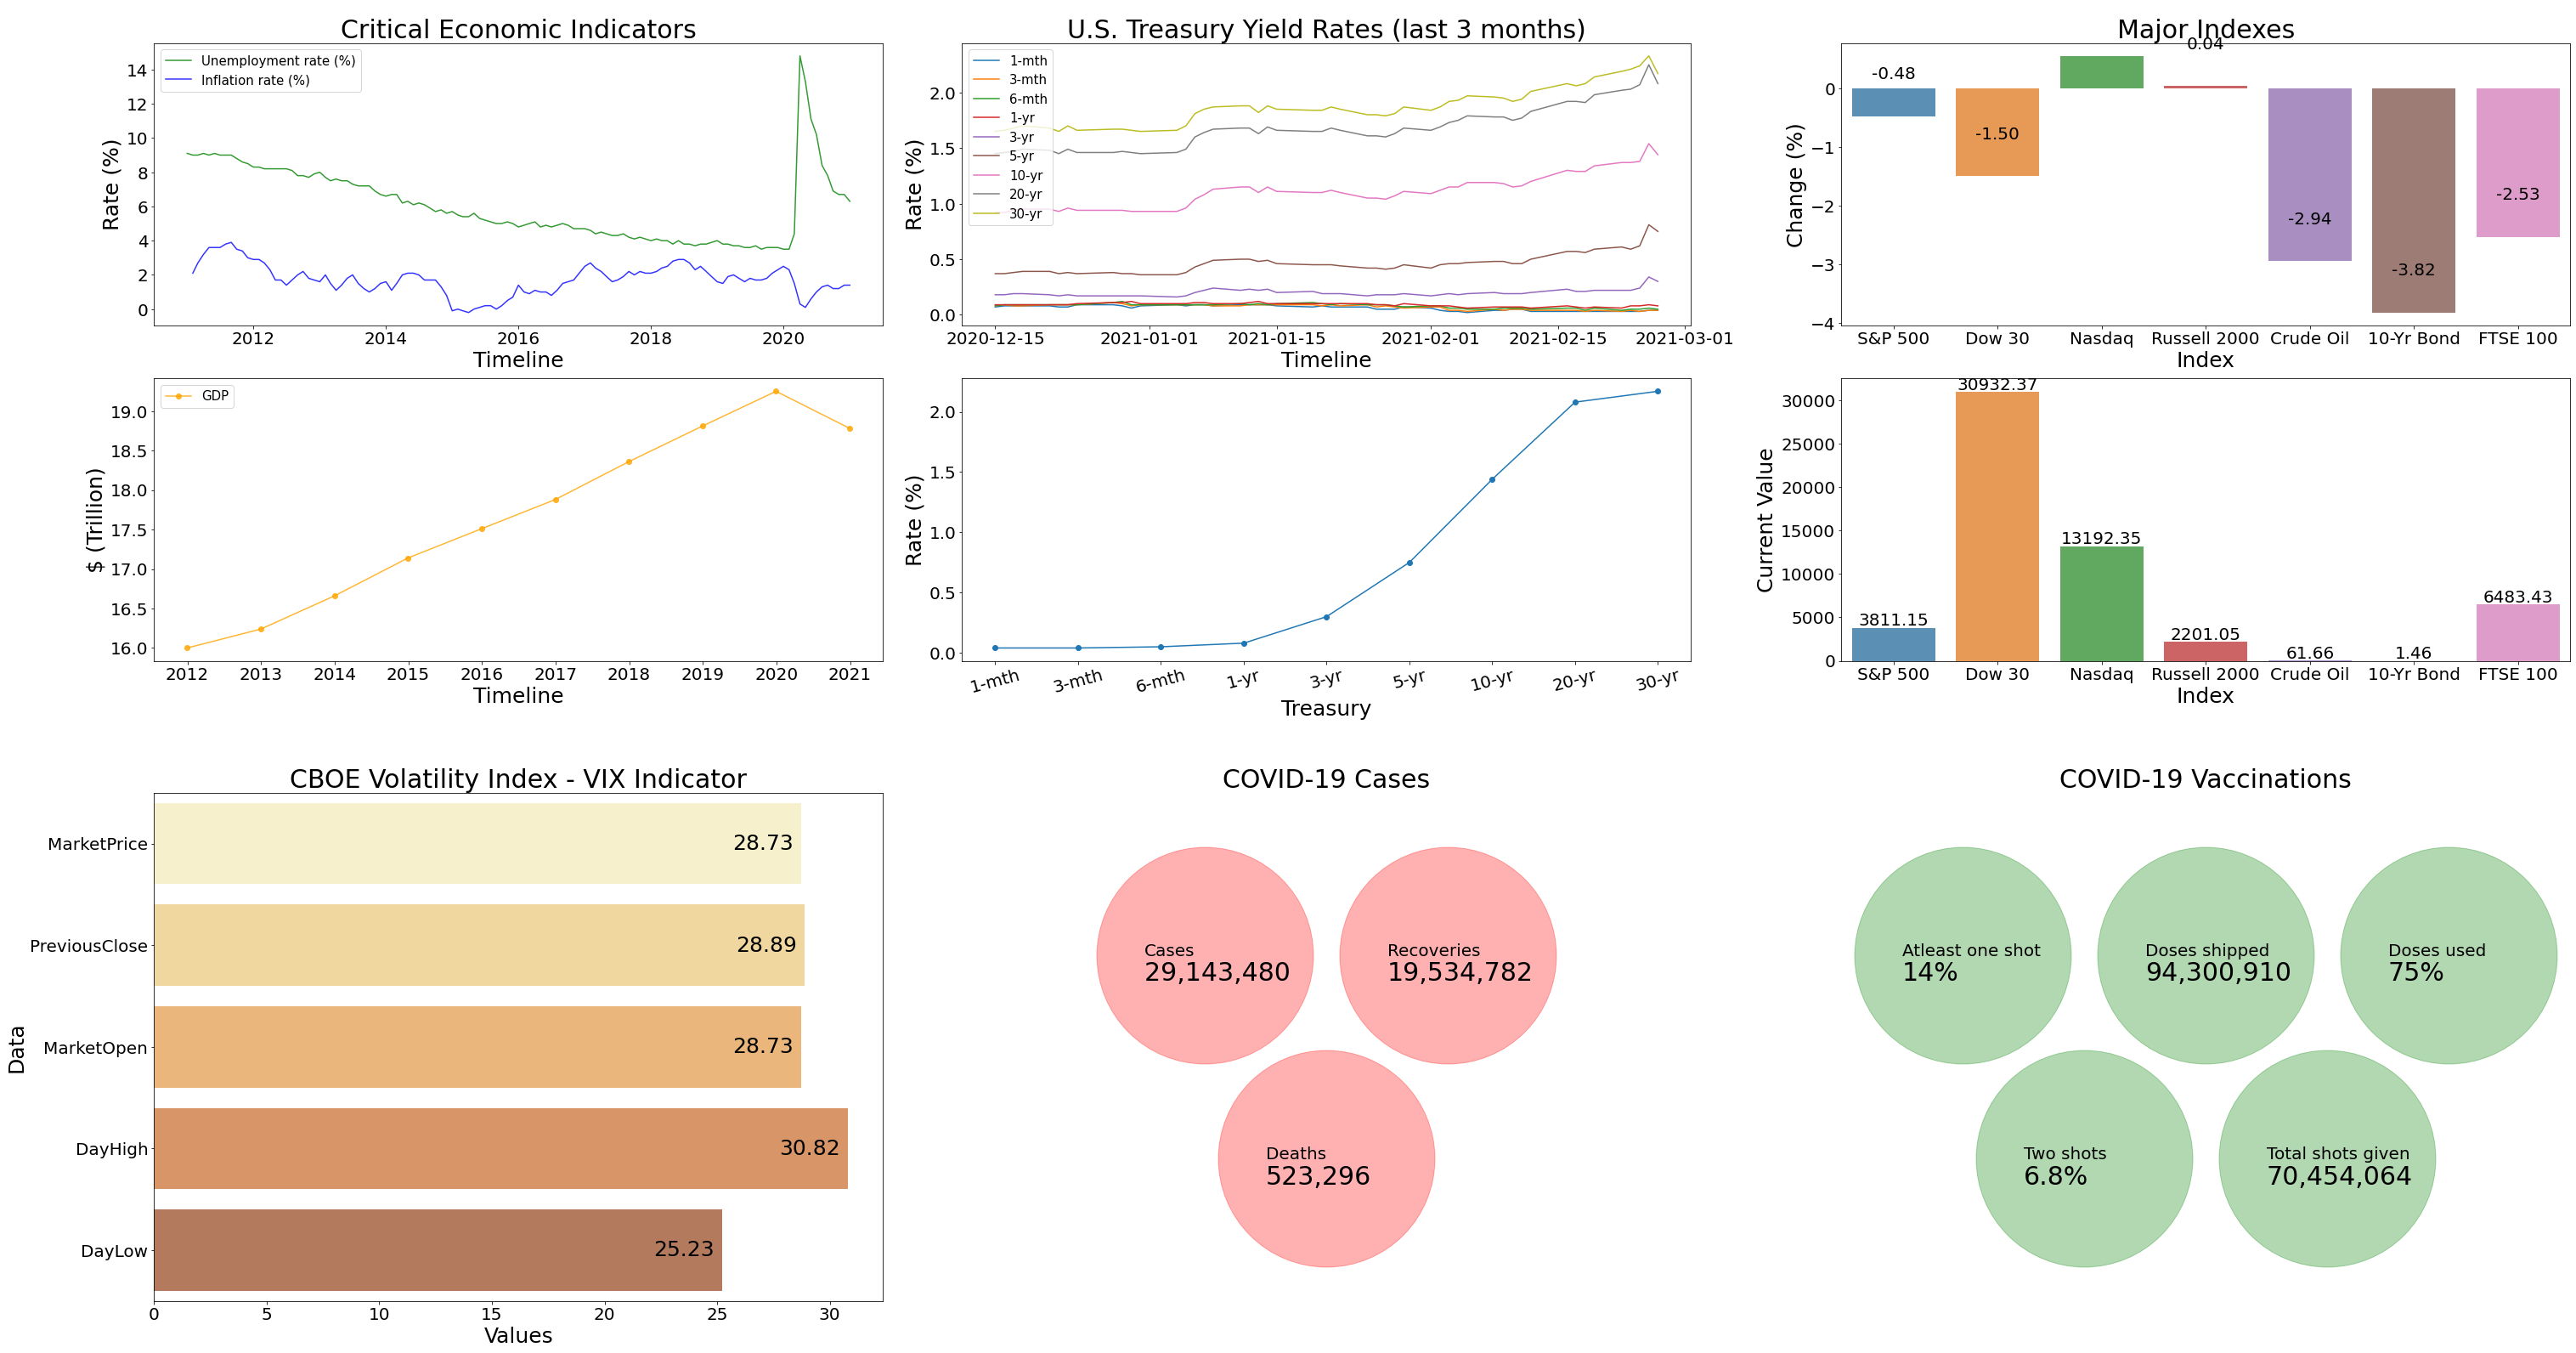

In [83]:
dash_create()